# PJM System Net Load & Price Analysis

This notebook rebuilds the PJM system-level net load and price analytics with proper scope alignment (RTO-only) and consistent timestamp handling in Eastern Prevailing Time (EPT).

## Dataset Issues
- Mixed geographies: subtracting fleet-wide renewables from regional/zonal load created a mismatched net-load metric.
- Price pairing errors: PJM-RTO prices were compared to non-RTO load forecasts.
- Timestamp drift: sources were merged without normalizing to the same EPT-aware clock, shifting series relative to each other.

The cells below correct these issues before any visualization or modeling.

In [127]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, root_mean_squared_error


DATA_DIR = Path("data")
PLOTS_DIR = Path("plots")
OUTPUT_DIR = Path("output_data")
CSV_PLOTS_DIR = Path("csv_plots")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
CSV_PLOTS_DIR.mkdir(parents=True, exist_ok=True)
EPT_TZ = "America/New_York"

plt.rcParams["axes.titleweight"] = "normal"


In [128]:
def to_ept(series):
    """Parse strings into timezone-aware EPT datetimes."""
    dt = pd.to_datetime(series, errors="coerce")
    return dt.dt.tz_localize(EPT_TZ, nonexistent="shift_forward", ambiguous="NaT")


def summarize_nulls(df, label):
    nulls = df.isna().mean()*100
    display(pd.DataFrame({"column": nulls.index, "pct_missing": nulls.values}).query("pct_missing > 0"))
    print(f"Checked missing data for {label}.")

## Load raw CSVs

In [129]:
df_load_raw = pd.read_csv(DATA_DIR / "historical_power_load.csv")
df_gen_raw = pd.read_csv(DATA_DIR / "generation_by_source.csv")
df_price_raw = pd.read_csv(DATA_DIR / "day_ahead_energy_price.csv")

print(
    f"Loaded {len(df_load_raw):,} load rows, {len(df_gen_raw):,} gen rows, {len(df_price_raw):,} price rows."
)

Loaded 713,394 load rows, 87,770 gen rows, 8,761 price rows.


## Prepare RTO load (system scope only)

In [130]:
df_load_rto = df_load_raw[df_load_raw["forecast_area"] == "RTO"].copy()
df_load_rto["hour_beginning_ept"] = to_ept(df_load_rto["forecast_hour_beginning_ept"])
df_load_rto["evaluated_at_ept"] = to_ept(df_load_rto["evaluated_at_ept"])

# Keep the latest forecast for each delivery hour to avoid double-counting
load_latest = (
    df_load_rto
    .dropna(subset=["hour_beginning_ept"])
    .sort_values(["hour_beginning_ept", "evaluated_at_ept"])
    .drop_duplicates("hour_beginning_ept", keep="last")
)

df_load_clean = load_latest[["hour_beginning_ept", "forecast_load_mw"]].rename(
    columns={"forecast_load_mw": "rto_load_mw"}
)

print(f"Prepared {len(df_load_clean):,} hourly RTO load records.")

/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_80669/4152324329.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(series, errors="coerce")


Prepared 8,743 hourly RTO load records.


## Aggregate renewable generation (system-wide)

In [131]:
df_gen = df_gen_raw.copy()
df_gen["hour_beginning_ept"] = to_ept(df_gen["datetime_beginning_ept"])

renewable_mask = df_gen["is_renewable"].astype(bool)
df_renew_hourly_fuel = (
    df_gen.loc[renewable_mask, ["hour_beginning_ept", "fuel_type", "mw"]]
    .dropna(subset=["hour_beginning_ept"])
    .groupby(["hour_beginning_ept", "fuel_type"], as_index=False)["mw"].sum()
    .rename(columns={"mw": "renewable_mw"})
)

df_renew_total = (
    df_renew_hourly_fuel
    .groupby("hour_beginning_ept", as_index=False)["renewable_mw"].sum()
    .rename(columns={"renewable_mw": "renewable_mw"})
)

print(f"Prepared {len(df_renew_total):,} hourly renewable totals across {df_renew_hourly_fuel['fuel_type'].nunique()} fuel types.")


nonrenewable_mask = ~renewable_mask
_df_nonrenew = (
    df_gen.loc[nonrenewable_mask, ["hour_beginning_ept", "fuel_type", "mw"]]
    .dropna(subset=["hour_beginning_ept"])
    .groupby(["hour_beginning_ept", "fuel_type"], as_index=False)["mw"].sum()
)
df_nonrenew_hourly_fuel = _df_nonrenew.rename(columns={"mw": "nonrenewable_mw"})


/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_80669/4152324329.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(series, errors="coerce")


Prepared 8,775 hourly renewable totals across 4 fuel types.


## Filter PJM-RTO prices and merge datasets

In [132]:
df_price_rto = df_price_raw[df_price_raw["pnode_name"] == "PJM-RTO"].copy()
df_price_rto["hour_beginning_ept"] = to_ept(df_price_rto["datetime_beginning_ept"])

df_price_clean = df_price_rto.dropna(subset=["hour_beginning_ept"])[[
    "hour_beginning_ept", "system_energy_price_da"
]]

merged = (
    df_load_clean
    .merge(df_renew_total, on="hour_beginning_ept", how="inner", validate="one_to_one")
    .merge(df_price_clean, on="hour_beginning_ept", how="inner", validate="one_to_one")
    .sort_values("hour_beginning_ept")
    .reset_index(drop=True)
)

merged["net_load_mw"] = merged["rto_load_mw"] - merged["renewable_mw"]
merged = merged.dropna(subset=["net_load_mw", "system_energy_price_da"])

print(f"Merged dataset contains {len(merged):,} aligned PJM-RTO hours.")
merged.head()

/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_80669/4152324329.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  dt = pd.to_datetime(series, errors="coerce")


Merged dataset contains 8,719 aligned PJM-RTO hours.


,hour_beginning_ept,rto_load_mw,renewable_mw,system_energy_price_da,net_load_mw
0,2023-10-06 00:00:00-04:00,74831,5138,20.98,69693
1,2023-10-06 01:00:00-04:00,71800,4638,19.40,67162
2,2023-10-06 02:00:00-04:00,69920,4674,17.80,65246
3,2023-10-06 03:00:00-04:00,68972,4820,17.24,64152
4,2023-10-06 04:00:00-04:00,70060,4651,18.04,65409


## Feature engineering for cyclic analysis

In [133]:
analysis_df = merged.copy()
analysis_df["month"] = analysis_df["hour_beginning_ept"].dt.month
analysis_df["month_name"] = analysis_df["hour_beginning_ept"].dt.strftime("%b")
analysis_df["day_name"] = analysis_df["hour_beginning_ept"].dt.day_name()
analysis_df["hour"] = analysis_df["hour_beginning_ept"].dt.hour
analysis_df["date"] = analysis_df["hour_beginning_ept"].dt.date
analysis_df["week"] = analysis_df["hour_beginning_ept"].dt.isocalendar().week.astype(int)

analysis_df.head()

,hour_beginning_ept,rto_load_mw,renewable_mw,system_energy_price_da,net_load_mw,month,month_name,day_name,hour,date,week
0,2023-10-06 00:00:00-04:00,74831,5138,20.98,69693,10,Oct,Friday,0,2023-10-06,40
1,2023-10-06 01:00:00-04:00,71800,4638,19.40,67162,10,Oct,Friday,1,2023-10-06,40
2,2023-10-06 02:00:00-04:00,69920,4674,17.80,65246,10,Oct,Friday,2,2023-10-06,40
3,2023-10-06 03:00:00-04:00,68972,4820,17.24,64152,10,Oct,Friday,3,2023-10-06,40
4,2023-10-06 04:00:00-04:00,70060,4651,18.04,65409,10,Oct,Friday,4,2023-10-06,40


## Plotting utilities

In [134]:

CATEGORY_ORDER = {
    "day_name": ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    "month_name": ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
}

DEFAULT_LINE_FIGSIZE = (10, 4)
SCATTER_FIGSIZE = (9, 6)
AREA_FIGSIZE = (10, 5)


def save_fig(fig, name):
    fig.tight_layout()
    path = PLOTS_DIR / f"{name}.png"
    fig.savefig(path, bbox_inches="tight", dpi=300)
    plt.show()
    plt.close(fig)
    print(f"Saved {path}")


def save_plot_data(df, name):
    path = CSV_PLOTS_DIR / f"{name}.csv"
    df.to_csv(path, index=False)
    print(f"Saved {path}")


def label_with_units(column_name, fallback):
    col = column_name.lower()
    if "price" in col:
        return "System Energy Price ($/MWh)"
    if "load" in col or "mw" in col:
        return f"{fallback} (MW)"
    return fallback


def hourly_average_plot(df, value_col, title, filename):
    hourly = (
        df.groupby("hour")[value_col].mean()
        .reindex(range(24))
        .reset_index()
        .rename(columns={value_col: "average_value"})
    )
    fig, ax = plt.subplots(figsize=DEFAULT_LINE_FIGSIZE)
    ax.plot(hourly["hour"], hourly["average_value"], linewidth=2, marker="o")
    ax.set_xticks(range(0, 24, 2))
    ax.set_xlabel("Hour of Day (EPT)")
    ax.set_ylabel(label_with_units(value_col, value_col.replace("_", " ").title()))
    ax.set_title(title)
    save_fig(fig, filename)
    save_plot_data(hourly, filename)


def category_average_plot(df, category, value_col, title, filename, order=None):
    grouped = df.groupby(category)[value_col].mean()
    if order is not None:
        grouped = grouped.reindex(order)
    grouped_df = grouped.reset_index().rename(columns={value_col: "average_value"})
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.bar(grouped_df[category], grouped_df["average_value"])
    ax.set_xlabel(category.replace("_", " ").title())
    ax.set_ylabel(label_with_units(value_col, value_col.replace("_", " ").title()))
    ax.set_title(title)
    ax.tick_params(axis="x", rotation=20)
    save_fig(fig, filename)
    save_plot_data(grouped_df, filename)


def stacked_hourly_renewables(df_hourly_fuel, filename):
    data = df_hourly_fuel.copy()
    data["hour"] = data["hour_beginning_ept"].dt.hour
    hourly_fuel = (
        data.groupby(["hour", "fuel_type"])["renewable_mw"].mean().reset_index()
    )
    pivot = hourly_fuel.pivot(index="hour", columns="fuel_type", values="renewable_mw").fillna(0)
    fig, ax = plt.subplots(figsize=AREA_FIGSIZE)
    pivot.plot.area(ax=ax)
    ax.set_xlabel("Hour of Day (EPT)")
    ax.set_ylabel("Average Renewable MW")
    ax.set_title("Average hourly renewable generation by fuel")
    ax.set_xticks(range(0, 24, 2))
    ax.legend(title="Fuel", bbox_to_anchor=(1.02, 1), loc="upper left")
    save_fig(fig, filename)
    save_plot_data(pivot.reset_index(), filename)


def monthly_renewables(df_total, filename):
    monthly = (
        df_total.assign(month=lambda d: d["hour_beginning_ept"].dt.to_period("M"))
        .groupby("month")["renewable_mw"].sum()
        .reset_index()
        .rename(columns={"renewable_mw": "total_renewable_mwh"})
    )
    monthly["month"] = monthly["month"].astype(str)
    fig, ax = plt.subplots(figsize=DEFAULT_LINE_FIGSIZE)
    ax.plot(monthly["month"], monthly["total_renewable_mwh"], marker="o")
    ax.set_xlabel("Month")
    ax.set_ylabel("Renewable MWh")
    ax.set_title("Monthly renewable generation (sum)")
    ax.tick_params(axis="x", rotation=45)
    save_fig(fig, filename)
    save_plot_data(monthly, filename)


def _ordered_categories(series, key):
    order = CATEGORY_ORDER.get(key)
    if order:
        return [cat for cat in order if cat in set(series.dropna())]
    try:
        return sorted(series.dropna().unique())
    except TypeError:
        return list(series.dropna().unique())


def scatter_with_hue(df, hue, title, filename):
    fig, ax = plt.subplots(figsize=SCATTER_FIGSIZE)
    series = df[hue]
    categories = _ordered_categories(series, hue)
    for cat in categories:
        mask = series == cat
        ax.scatter(
            df.loc[mask, "net_load_mw"],
            df.loc[mask, "system_energy_price_da"],
            label=str(cat),
            s=30,
            alpha=0.7,
        )
    ax.set_xlabel("Net Load (MW)")
    ax.set_ylabel("System Energy Price ($/MWh)")
    ax.set_title(title)
    ax.legend(title=hue.replace("_", " ").title(), bbox_to_anchor=(1.02, 1), loc="upper left")
    save_fig(fig, filename)
    save_plot_data(
        df[["net_load_mw", "system_energy_price_da", hue]].dropna().rename(
            columns={"net_load_mw": "net_load_mw", "system_energy_price_da": "system_energy_price_da", hue: hue}
        ),
        filename,
    )


def binned_price_plot(df, filename, bins=50):
    tmp = df.copy()
    tmp["net_bin"] = pd.cut(tmp["net_load_mw"], bins=bins)
    grouped = (
        tmp.groupby("net_bin")[["net_load_mw", "system_energy_price_da"]].mean().reset_index()
    )
    grouped = grouped.rename(
        columns={"net_load_mw": "net_load_center", "system_energy_price_da": "avg_price"}
    )
    fig, ax = plt.subplots(figsize=DEFAULT_LINE_FIGSIZE)
    ax.plot(grouped["net_load_center"], grouped["avg_price"], marker="o")
    ax.set_xlabel("Net Load bin center (MW)")
    ax.set_ylabel("Average Price ($/MWh)")
    ax.set_title("Binned average price vs net load")
    save_fig(fig, filename)
    save_plot_data(grouped, filename)


def histogram_plot(df, column, title, filename, bins=40):
    values = df[column].dropna().reset_index(drop=True)
    fig, ax = plt.subplots(figsize=DEFAULT_LINE_FIGSIZE)
    ax.hist(values, bins=bins, edgecolor="#1b1b1b", alpha=0.85)
    ax.set_xlabel(label_with_units(column, column.replace("_", " ").title()))
    ax.set_ylabel("Number of Hours")
    ax.set_title(title)
    save_fig(fig, filename)
    save_plot_data(pd.DataFrame({column: values}), filename)


## Cyclicality diagnostics (system energy price & renewables)

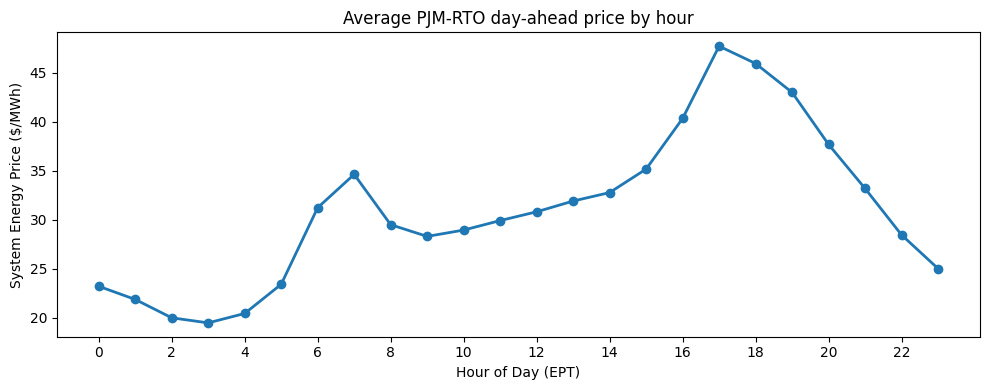

Saved plots/price_hourly_avg.png
Saved csv_plots/price_hourly_avg.csv


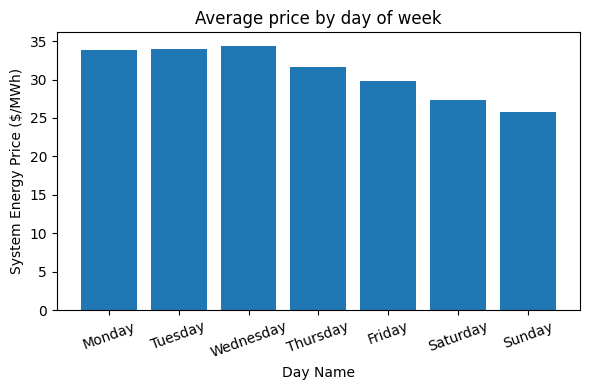

Saved plots/price_day_of_week.png
Saved csv_plots/price_day_of_week.csv


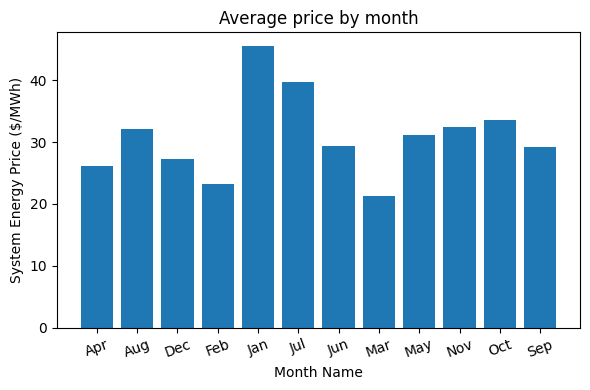

Saved plots/price_monthly_avg.png
Saved csv_plots/price_monthly_avg.csv


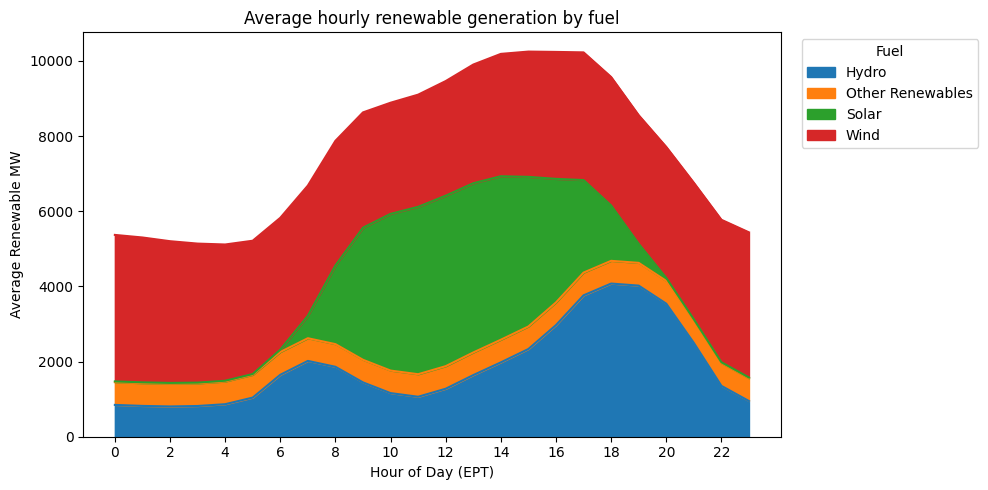

Saved plots/renewables_hourly_breakdown.png
Saved csv_plots/renewables_hourly_breakdown.csv


/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_80669/1859514851.py:87: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_total.assign(month=lambda d: d["hour_beginning_ept"].dt.to_period("M"))


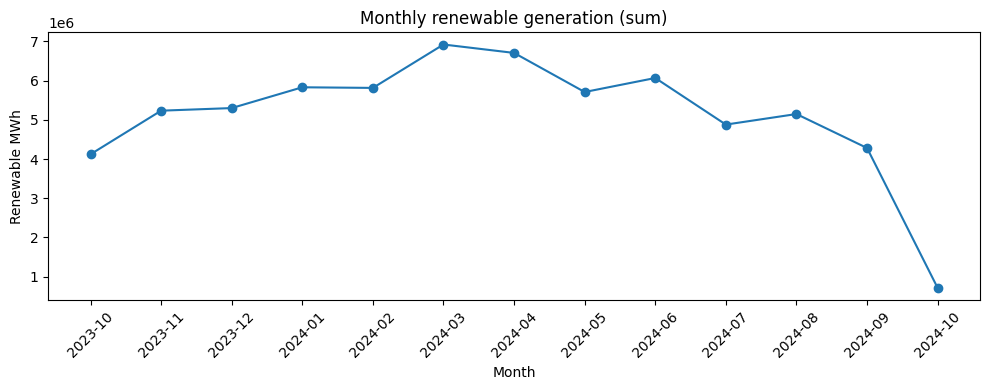

Saved plots/renewables_monthly_total.png
Saved csv_plots/renewables_monthly_total.csv


In [135]:
hourly_average_plot(
    analysis_df,
    value_col="system_energy_price_da",
    title="Average PJM-RTO day-ahead price by hour",
    filename="price_hourly_avg"
)

category_average_plot(
    analysis_df,
    category="day_name",
    value_col="system_energy_price_da",
    title="Average price by day of week",
    filename="price_day_of_week",
    order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)

category_average_plot(
    analysis_df,
    category="month_name",
    value_col="system_energy_price_da",
    title="Average price by month",
    filename="price_monthly_avg"
)

stacked_hourly_renewables(df_renew_hourly_fuel, filename="renewables_hourly_breakdown")

monthly_renewables(df_renew_total, filename="renewables_monthly_total")

### Price cyclicality takeaways
- Hourly profile tracks behavioural load: early mornings sit in the mid-\$20s/MWh before office, HVAC, and industrial demand push prices 10–15 \$/MWh higher through the afternoon.
- Weekdays hold the premium because commercial demand dominates; Saturday/Sunday flatten out, consistent with the net-load heatmap.
- Monthly averages skew high in January/July when heating/cooling demand is extreme, while shoulder months (Apr/Oct) pair softer prices with higher renewable penetration.


## Load and renewable interplay

Overlaying system load, renewable output, and derived net load across key horizons clarifies how renewables reshape the demand that prices must clear.

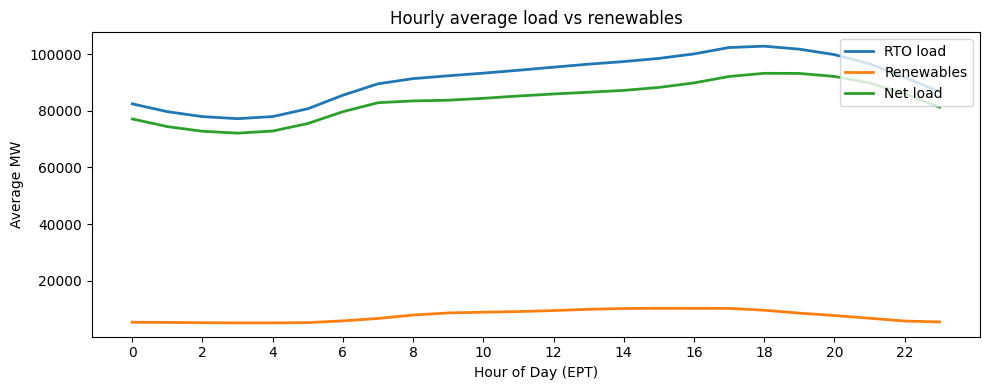

Saved plots/hourly_load_vs_renewables.png
Saved csv_plots/hourly_load_vs_renewables.csv


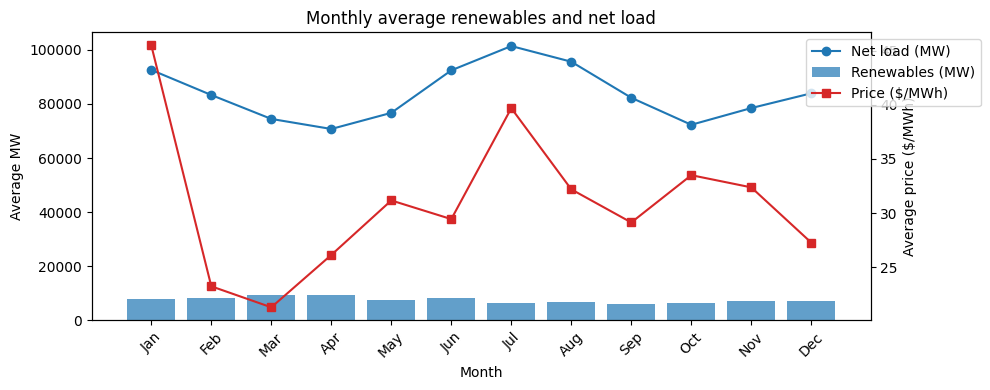

Saved plots/monthly_renewables_netload_price.png
Saved csv_plots/monthly_renewables_netload_price.csv


In [136]:

hourly_mix = (
    analysis_df.groupby("hour")[["rto_load_mw", "renewable_mw", "net_load_mw", "system_energy_price_da"]]
    .mean()
    .reindex(range(24))
    .reset_index()
)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(hourly_mix["hour"], hourly_mix["rto_load_mw"], label="RTO load", linewidth=2)
ax.plot(hourly_mix["hour"], hourly_mix["renewable_mw"], label="Renewables", linewidth=2)
ax.plot(hourly_mix["hour"], hourly_mix["net_load_mw"], label="Net load", linewidth=2)
ax.set_xticks(range(0, 24, 2))
ax.set_xlabel("Hour of Day (EPT)")
ax.set_ylabel("Average MW")
ax.set_title("Hourly average load vs renewables")
ax.legend(loc="upper right")
save_fig(fig, "hourly_load_vs_renewables")
save_plot_data(hourly_mix.rename(columns={"hour": "hour_of_day"}), "hourly_load_vs_renewables")

month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
monthly_mix = (
    analysis_df.groupby("month_name")[["rto_load_mw", "renewable_mw", "net_load_mw", "system_energy_price_da"]]
    .mean()
    .reindex(month_order)
    .reset_index()
    .dropna(subset=["month_name"])
)
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(monthly_mix["month_name"], monthly_mix["renewable_mw"], label="Renewables (MW)", alpha=0.7)
ax.plot(monthly_mix["month_name"], monthly_mix["net_load_mw"], color="tab:blue", marker="o", label="Net load (MW)")
ax.set_xlabel("Month")
ax.set_ylabel("Average MW")
ax.set_title("Monthly average renewables and net load")
ax.tick_params(axis="x", rotation=45)
ax2 = ax.twinx()
ax2.plot(monthly_mix["month_name"], monthly_mix["system_energy_price_da"], color="tab:red", marker="s", label="Price ($/MWh)")
ax2.set_ylabel("Average price ($/MWh)")
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper right", bbox_to_anchor=(1.15, 1))
save_fig(fig, "monthly_renewables_netload_price")
save_plot_data(monthly_mix.rename(columns={"month_name": "month"}), "monthly_renewables_netload_price")


### Load vs renewable overlays
- Hourly overlay is the PJM duck curve: renewables carve a midday valley yet net load still peaks late afternoon when HVAC, industry, cooking, and EV charging stack up; lighting alone would not create this magnitude.
- Weekday vs weekend gap lines up with commercial demand—Monday through Friday sit 5–8 GW higher even at night because industrial processes rarely shut down completely.
- Monthly panel shows renewable-rich shoulder months softening net load and price, whereas winter heating season keeps net load elevated when renewables underperform.


## Renewable cyclicality by fuel

Fuel-level views highlight when wind, solar, hydro, and other renewable fleets shape PJM net load the most.

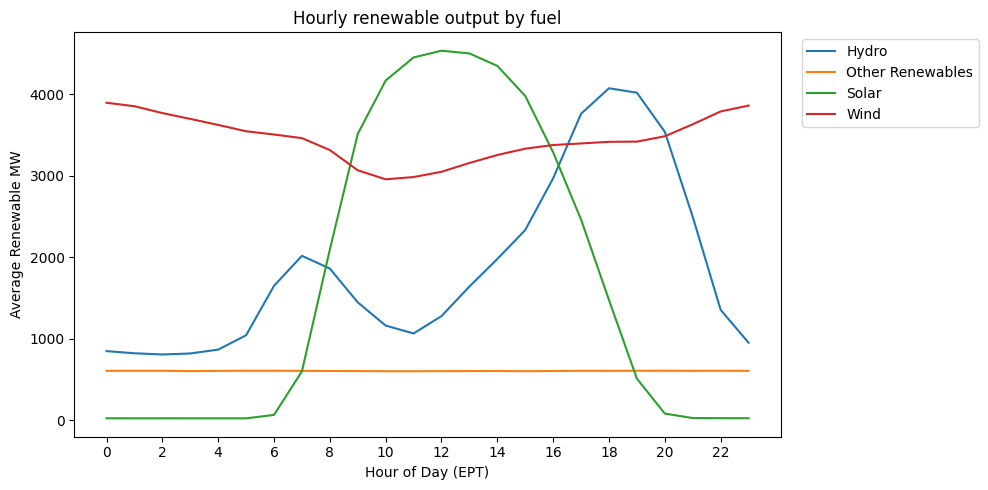

Saved plots/renewables_fuel_hourly_line.png
Saved csv_plots/renewables_fuel_hourly_line.csv


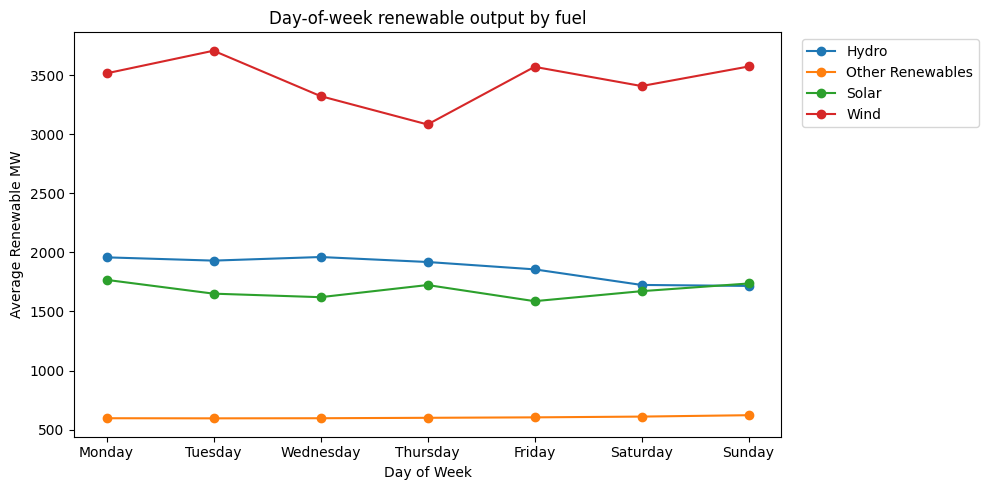

Saved plots/renewables_fuel_weekday_line.png
Saved csv_plots/renewables_fuel_weekday_line.csv


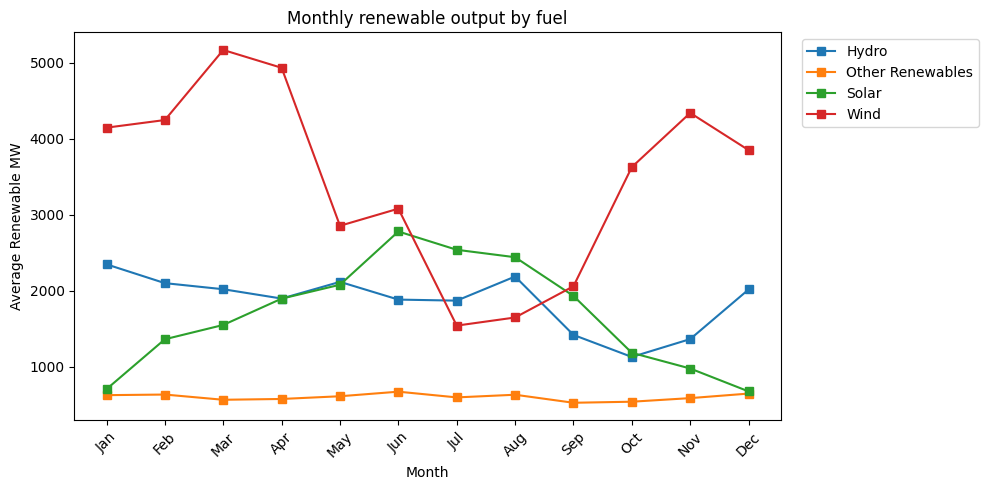

Saved plots/renewables_fuel_monthly_line.png
Saved csv_plots/renewables_fuel_monthly_line.csv


In [137]:

renew_fuel = df_renew_hourly_fuel.copy()
renew_fuel["hour"] = renew_fuel["hour_beginning_ept"].dt.hour
renew_fuel["day_name"] = renew_fuel["hour_beginning_ept"].dt.day_name()
renew_fuel["month_name"] = renew_fuel["hour_beginning_ept"].dt.strftime("%b")

# Hourly profiles
hourly_fuel = (
    renew_fuel.groupby(["fuel_type", "hour"])["renewable_mw"].mean().reset_index()
)
fig, ax = plt.subplots(figsize=(10, 5))
for fuel, grp in hourly_fuel.groupby("fuel_type"):
    ax.plot(grp["hour"], grp["renewable_mw"], label=fuel)
ax.set_xlabel("Hour of Day (EPT)")
ax.set_ylabel("Average Renewable MW")
ax.set_title("Hourly renewable output by fuel")
ax.set_xticks(range(0, 24, 2))
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
save_fig(fig, "renewables_fuel_hourly_line")
save_plot_data(hourly_fuel.rename(columns={"renewable_mw": "average_mw"}), "renewables_fuel_hourly_line")

# Day-of-week profiles
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
daily_fuel = (
    renew_fuel.groupby(["fuel_type", "day_name"])["renewable_mw"].mean().reset_index()
)
fig, ax = plt.subplots(figsize=(10, 5))
for fuel, grp in daily_fuel.groupby("fuel_type"):
    grp_sorted = grp.set_index("day_name").reindex(day_order).reset_index()
    ax.plot(grp_sorted["day_name"], grp_sorted["renewable_mw"], marker="o", label=fuel)
ax.set_xlabel("Day of Week")
ax.set_ylabel("Average Renewable MW")
ax.set_title("Day-of-week renewable output by fuel")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
save_fig(fig, "renewables_fuel_weekday_line")
save_plot_data(
    daily_fuel.rename(columns={"renewable_mw": "average_mw"}),
    "renewables_fuel_weekday_line",
)

# Monthly profiles
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
monthly_fuel = (
    renew_fuel.groupby(["fuel_type", "month_name"])["renewable_mw"].mean().reset_index()
)
fig, ax = plt.subplots(figsize=(10, 5))
for fuel, grp in monthly_fuel.groupby("fuel_type"):
    grp_sorted = grp.set_index("month_name").reindex(month_order).reset_index()
    ax.plot(grp_sorted["month_name"], grp_sorted["renewable_mw"], marker="s", label=fuel)
ax.set_xlabel("Month")
ax.set_ylabel("Average Renewable MW")
ax.set_title("Monthly renewable output by fuel")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
ax.tick_params(axis="x", rotation=45)
save_fig(fig, "renewables_fuel_monthly_line")
save_plot_data(
    monthly_fuel.rename(columns={"renewable_mw": "average_mw"}),
    "renewables_fuel_monthly_line",
)


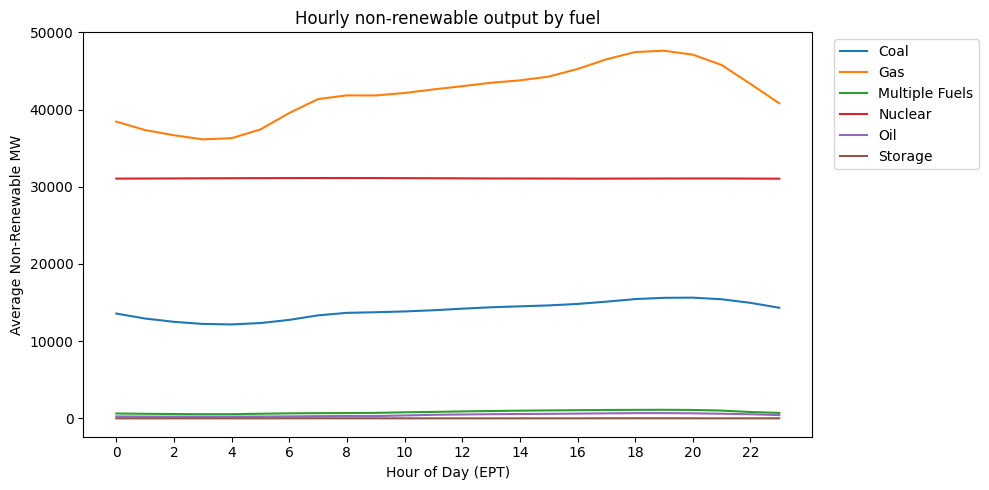

Saved plots/nonrenewables_fuel_hourly_line.png
Saved csv_plots/nonrenewables_fuel_hourly_line.csv


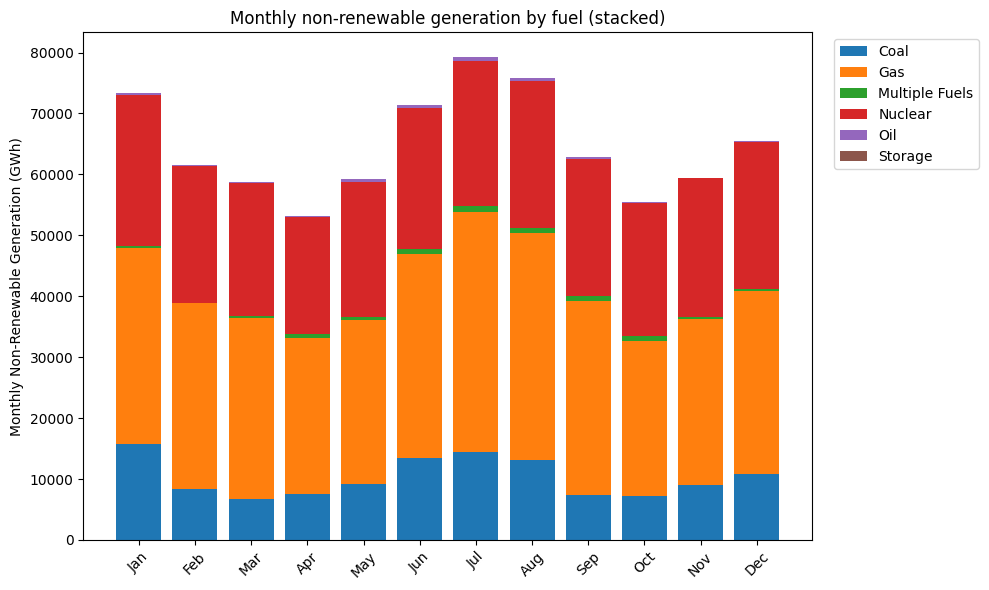

Saved plots/nonrenewables_fuel_monthly_stack.png
Saved csv_plots/nonrenewables_fuel_monthly_stack.csv


In [138]:

nonrenew_fuel = df_nonrenew_hourly_fuel.copy()
nonrenew_fuel["hour"] = nonrenew_fuel["hour_beginning_ept"].dt.hour
nonrenew_fuel["month_name"] = nonrenew_fuel["hour_beginning_ept"].dt.strftime("%b")

# Hourly averages by non-renewable fuel
hourly_nonrenew = (
    nonrenew_fuel.groupby(["fuel_type", "hour"])["nonrenewable_mw"].mean().reset_index()
)
fig, ax = plt.subplots(figsize=(10, 5))
for fuel, grp in hourly_nonrenew.groupby("fuel_type"):
    ax.plot(grp["hour"], grp["nonrenewable_mw"], label=fuel)
ax.set_xlabel("Hour of Day (EPT)")
ax.set_ylabel("Average Non-Renewable MW")
ax.set_title("Hourly non-renewable output by fuel")
ax.set_xticks(range(0, 24, 2))
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
save_fig(fig, "nonrenewables_fuel_hourly_line")
save_plot_data(
    hourly_nonrenew.rename(columns={"nonrenewable_mw": "average_mw"}),
    "nonrenewables_fuel_hourly_line",
)

# Monthly summed generation by non-renewable fuel (GWh)
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
monthly_nonrenew = (
    nonrenew_fuel.groupby(["fuel_type", "month_name"])["nonrenewable_mw"].sum().reset_index()
)
monthly_nonrenew["gwh"] = monthly_nonrenew["nonrenewable_mw"] / 1000  # MW->GWh per hour
stack = (
    monthly_nonrenew
    .pivot(index="month_name", columns="fuel_type", values="gwh")
    .reindex(month_order)
    .fillna(0)
)
fig, ax = plt.subplots(figsize=(10, 6))
bottom = np.zeros(len(stack))
for fuel in stack.columns:
    ax.bar(stack.index, stack[fuel], bottom=bottom, label=fuel)
    bottom += stack[fuel].values
ax.set_ylabel("Monthly Non-Renewable Generation (GWh)")
ax.set_title("Monthly non-renewable generation by fuel (stacked)")
ax.tick_params(axis="x", rotation=45)
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
save_fig(fig, "nonrenewables_fuel_monthly_stack")
save_plot_data(
    monthly_nonrenew[["fuel_type", "month_name", "gwh"]],
    "nonrenewables_fuel_monthly_stack",
)



### Non-renewable fuel mix
- Gas, coal, and nuclear dominate the hourly output curve; gas flexes hardest intraday, while nuclear stays nearly flat, underscoring why gas volatility still drives the residual spikes noted earlier.
- Monthly stacked totals show winter leaning more on gas/coal while summer sees gas plus oil peakers surge; the composition mirrors the scarcity narratives from the regression plots.


### Renewable fuel cycles
- Wind-heavy fuels keep overnight output elevated, explaining why some off-peak hours show unexpectedly low net load even when solar is absent.
- Solar dominates 8 A.M.–6 P.M., with the steepest ramps in summer; this aligns with the load overlay where midday net load collapses.
- Hydro/other renewables add a steady floor, becoming proportionally more important during calm or cloudy periods.


## Load vs renewable heatmaps

Heatmaps across hours and weekdays highlight when renewable supply most effectively trims PJM net load.

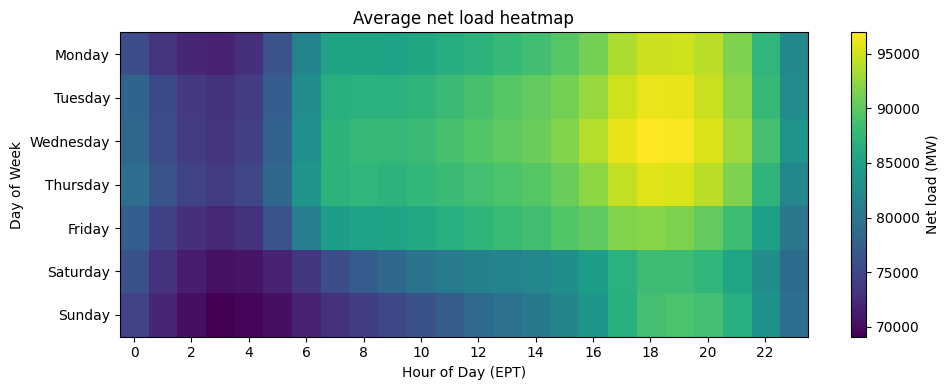

Saved plots/heatmap_net_load_weekday.png
Saved csv_plots/heatmap_net_load_weekday.csv


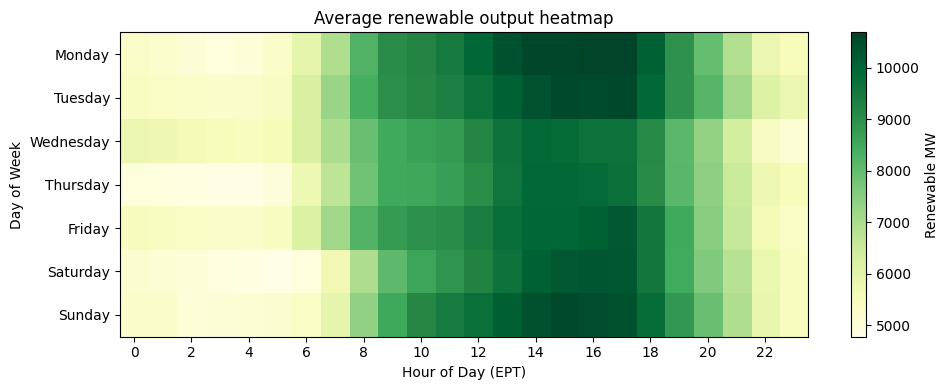

Saved plots/heatmap_renewable_weekday.png
Saved csv_plots/heatmap_renewable_weekday.csv


In [139]:

day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
heat_df = analysis_df.copy()
heat_df["day_name"] = heat_df["hour_beginning_ept"].dt.day_name()
heat_df["hour"] = heat_df["hour_beginning_ept"].dt.hour
net_heat = (
    heat_df.pivot_table(
        values="net_load_mw", index="day_name", columns="hour", aggfunc="mean"
    ).reindex(day_order)
)
fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(net_heat, aspect="auto", cmap="viridis")
ax.set_xticks(range(0,24,2))
ax.set_xticklabels(range(0,24,2))
ax.set_yticks(range(len(day_order)))
ax.set_yticklabels(day_order)
ax.set_xlabel("Hour of Day (EPT)")
ax.set_ylabel("Day of Week")
ax.set_title("Average net load heatmap")
fig.colorbar(im, ax=ax, label="Net load (MW)")
save_fig(fig, "heatmap_net_load_weekday")
save_plot_data(net_heat.reset_index().rename(columns={"index": "day_name"}), "heatmap_net_load_weekday")

ren_heat = (
    heat_df.pivot_table(
        values="renewable_mw", index="day_name", columns="hour", aggfunc="mean"
    ).reindex(day_order)
)
fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(ren_heat, aspect="auto", cmap="YlGn")
ax.set_xticks(range(0,24,2))
ax.set_xticklabels(range(0,24,2))
ax.set_yticks(range(len(day_order)))
ax.set_yticklabels(day_order)
ax.set_xlabel("Hour of Day (EPT)")
ax.set_ylabel("Day of Week")
ax.set_title("Average renewable output heatmap")
fig.colorbar(im, ax=ax, label="Renewable MW")
save_fig(fig, "heatmap_renewable_weekday")
save_plot_data(ren_heat.reset_index().rename(columns={"index": "day_name"}), "heatmap_renewable_weekday")


### Heatmap insights
- Net load dips before sunrise, especially on weekends when commercial/industrial baseload disappears; weekdays maintain a higher floor because offices and factories are online.
- Daytime hours (06–18) light up with higher net load, matching HVAC/commercial activity more than household lighting.
- Renewable heatmap mirrors solar availability, showing why midday net load relief is strongest in summer and weakest on winter mornings.


## Net load vs price density

Density plots complement scatter charts by emphasizing the most common net-load/price regimes.

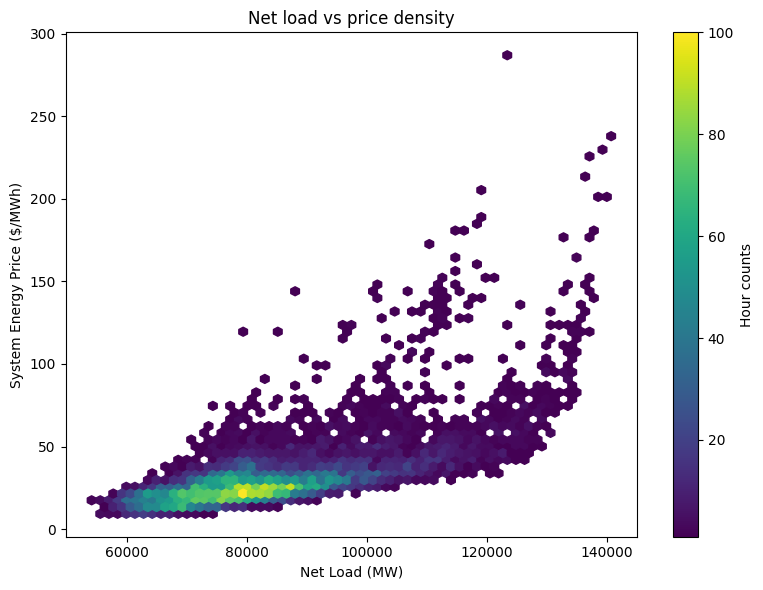

Saved plots/hexbin_netload_price_density.png
Saved csv_plots/hexbin_netload_price_density.csv


In [140]:

fig, ax = plt.subplots(figsize=(8, 6))
hb = ax.hexbin(
    analysis_df["net_load_mw"],
    analysis_df["system_energy_price_da"],
    gridsize=60,
    cmap="viridis",
    mincnt=1,
)
ax.set_xlabel("Net Load (MW)")
ax.set_ylabel("System Energy Price ($/MWh)")
ax.set_title("Net load vs price density")
cb = fig.colorbar(hb, ax=ax)
cb.set_label("Hour counts")
save_fig(fig, "hexbin_netload_price_density")
save_plot_data(
    analysis_df[["net_load_mw", "system_energy_price_da"]],
    "hexbin_netload_price_density",
)


### Net load vs price density
- The dense cluster near 95–110 GW and $20–40/MWh marks PJM’s “normal” regime.
- Sparse bins beyond ~125 GW confirm that scarcity hours are rare but carry outsized price impact.
- Low net-load bins (<80 GW) sit firmly in the discount zone, reinforcing how excess renewable output drags prices lower.


## Price vs renewable share

Relating price directly to renewable penetration shows how deeply renewables suppress PJM prices.

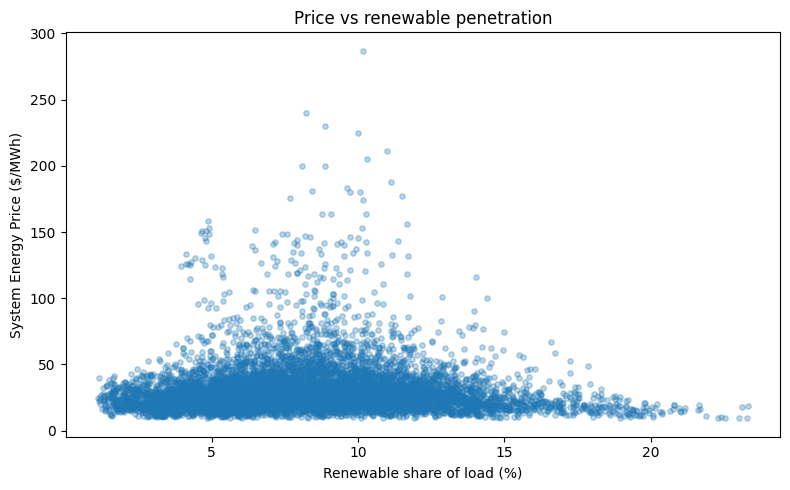

Saved plots/price_vs_renewable_share_scatter.png
Saved csv_plots/price_vs_renewable_share_scatter.csv


/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_80669/3615507679.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  share_df.groupby(bins)["system_energy_price_da"].mean().reset_index()


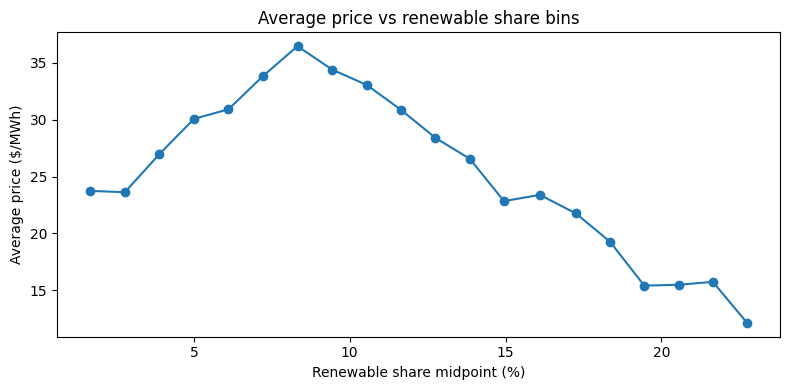

Saved plots/price_vs_renewable_share_binned.png
Saved csv_plots/price_vs_renewable_share_binned.csv


In [141]:

share_df = analysis_df.copy()
share_df["renewable_share"] = (share_df["renewable_mw"] / share_df["rto_load_mw"]).clip(upper=1.5)
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(
    share_df["renewable_share"] * 100,
    share_df["system_energy_price_da"],
    alpha=0.3,
    s=15,
)
ax.set_xlabel("Renewable share of load (%)")
ax.set_ylabel("System Energy Price ($/MWh)")
ax.set_title("Price vs renewable penetration")
save_fig(fig, "price_vs_renewable_share_scatter")
save_plot_data(
    share_df[["renewable_share", "system_energy_price_da"]],
    "price_vs_renewable_share_scatter",
)

bins = pd.cut(share_df["renewable_share"], bins=20)
share_binned = (
    share_df.groupby(bins)["system_energy_price_da"].mean().reset_index()
)
share_binned["share_mid"] = share_binned["renewable_share"].apply(lambda x: x.mid * 100)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(share_binned["share_mid"], share_binned["system_energy_price_da"], marker="o")
ax.set_xlabel("Renewable share midpoint (%)")
ax.set_ylabel("Average price ($/MWh)")
ax.set_title("Average price vs renewable share bins")
save_fig(fig, "price_vs_renewable_share_binned")
save_plot_data(
    share_binned[["share_mid", "system_energy_price_da"]],
    "price_vs_renewable_share_binned",
)


### Price vs renewable penetration
- Scatter shows a clear inverse slope: more of the load served by renewables means fewer gas peakers on the margin and cheaper clearing prices.
- Generators still chase renewables because of tax credits, renewable credits, and lower fuel-risk exposure—even if spot prices soften.
- Binned averages highlight diminishing returns: price sensitivity is steep when renewable share is below ~15%, then flattens as share rises.


## Rolling correlation between net load and price

Rolling correlations reveal when price stopped responding to net load (e.g., due to outages or fuel shocks).

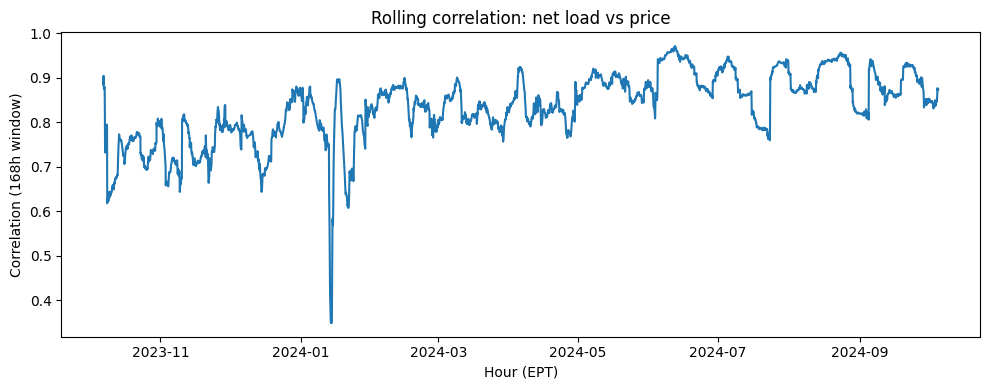

Saved plots/rolling_corr_netload_price.png
Saved csv_plots/rolling_corr_netload_price.csv


In [142]:

rolling_corr = (
    analysis_df["net_load_mw"].rolling(window=168, min_periods=24)
    .corr(analysis_df["system_energy_price_da"])
)
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(analysis_df["hour_beginning_ept"], rolling_corr)
ax.set_xlabel("Hour (EPT)")
ax.set_ylabel("Correlation (168h window)")
ax.set_title("Rolling correlation: net load vs price")
save_fig(fig, "rolling_corr_netload_price")
save_plot_data(
    pd.DataFrame({
        "timestamp": analysis_df["hour_beginning_ept"],
        "rolling_corr_168h": rolling_corr,
    }),
    "rolling_corr_netload_price",
)


### Rolling correlation highlights
- Net load and price usually track with correlation above 0.6, validating net load as the primary driver.
- The sharp January 2024 dip aligns with the EIA-documented Arctic blast (record U.S. gas demand on Jan 16), when fuel scarcity and emergency dispatch overwhelmed the standard relationship.
- Correlation stabilises again once weather and gas supply normalise, but late-2024 volatility keeps the metric from fully rebounding.


## Net load analysis

/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_80669/1483629544.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  roll = analysis_df["net_load_roll_24h"].fillna(method="bfill")


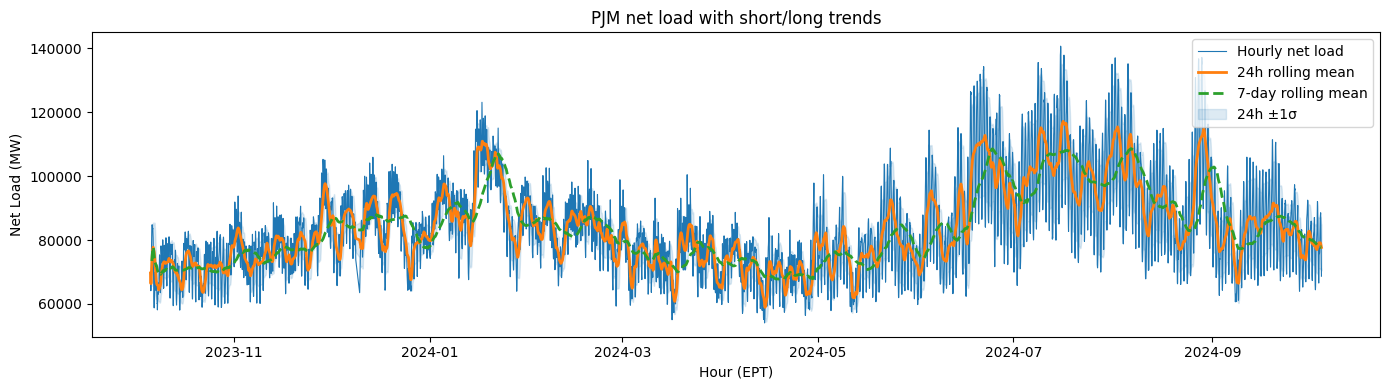

Saved plots/net_load_timeseries.png
Saved csv_plots/net_load_timeseries.csv


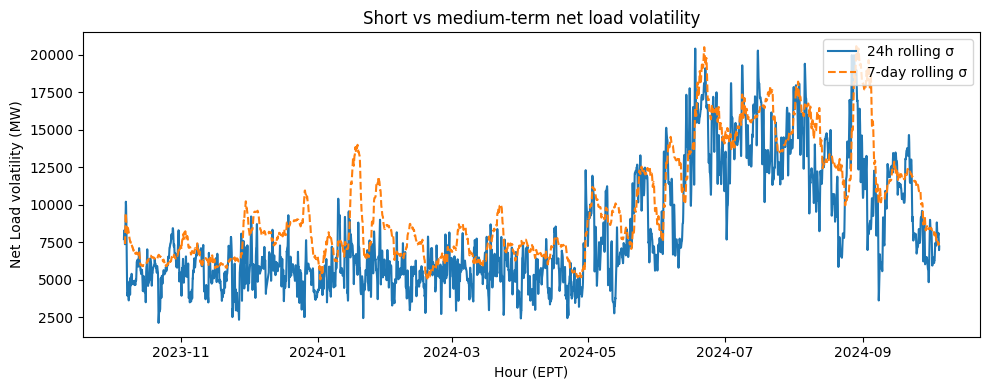

Saved plots/net_load_volatility.png
Saved csv_plots/net_load_volatility.csv


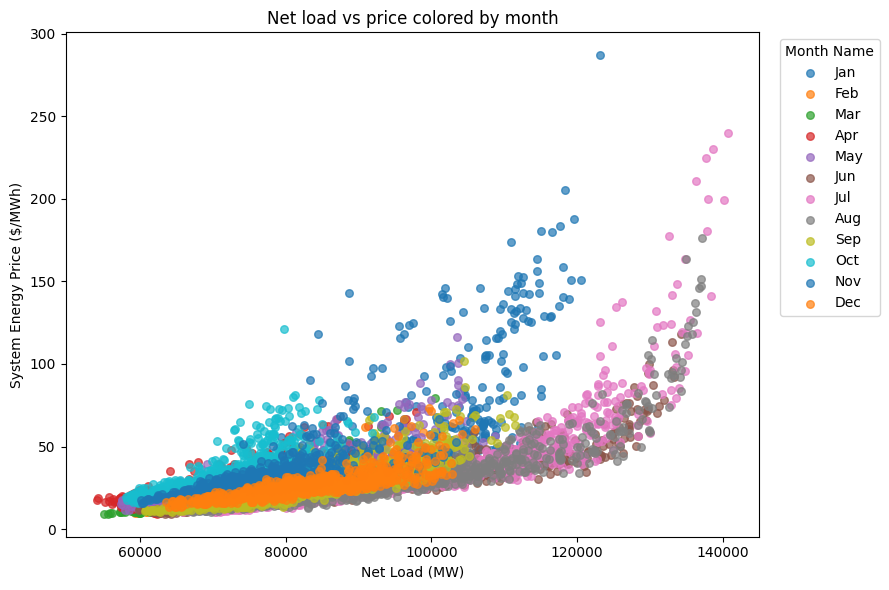

Saved plots/scatter_net_load_price_month.png
Saved csv_plots/scatter_net_load_price_month.csv


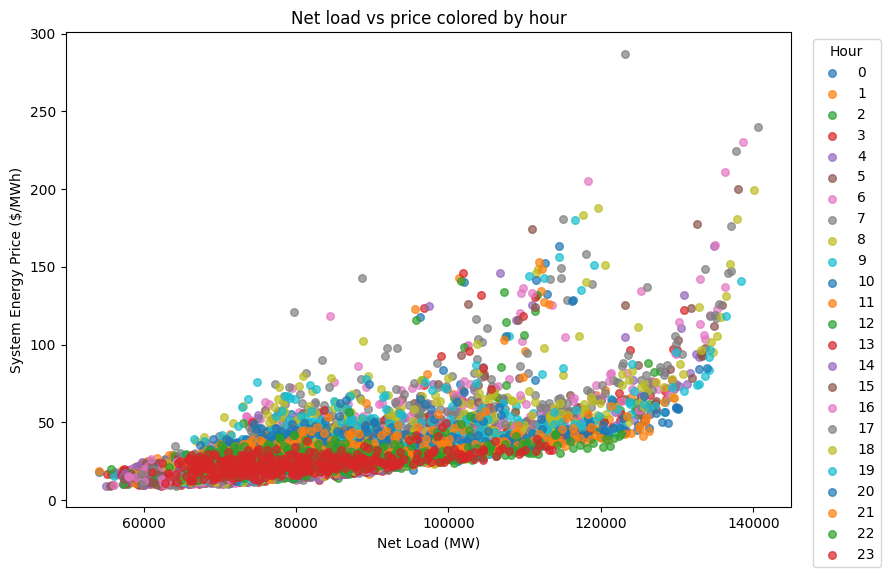

Saved plots/scatter_net_load_price_hour.png
Saved csv_plots/scatter_net_load_price_hour.csv


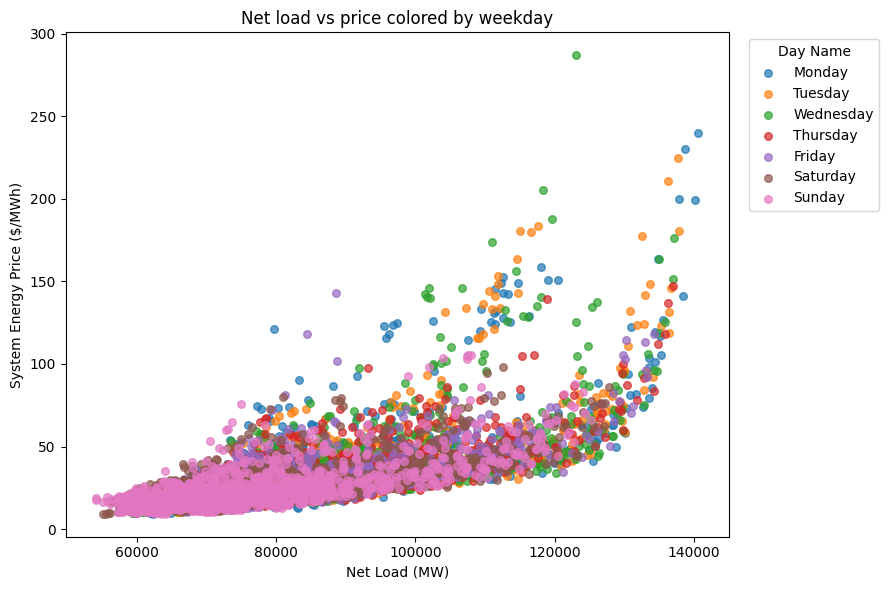

Saved plots/scatter_net_load_price_weekday.png
Saved csv_plots/scatter_net_load_price_weekday.csv


In [143]:

analysis_df = analysis_df.sort_values("hour_beginning_ept").reset_index(drop=True)
analysis_df["net_load_roll_24h"] = analysis_df["net_load_mw"].rolling(window=24, min_periods=1).mean()
analysis_df["net_load_roll_168h"] = analysis_df["net_load_mw"].rolling(window=168, min_periods=12).mean()
analysis_df["net_load_vol_24h"] = analysis_df["net_load_mw"].rolling(window=24, min_periods=12).std()
analysis_df["net_load_vol_168h"] = analysis_df["net_load_mw"].rolling(window=168, min_periods=24).std()

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(analysis_df["hour_beginning_ept"], analysis_df["net_load_mw"], linewidth=0.8, label="Hourly net load")
ax.plot(
    analysis_df["hour_beginning_ept"],
    analysis_df["net_load_roll_24h"],
    linewidth=2,
    label="24h rolling mean",
)
ax.plot(
    analysis_df["hour_beginning_ept"],
    analysis_df["net_load_roll_168h"],
    linewidth=2,
    linestyle="--",
    label="7-day rolling mean",
)
roll = analysis_df["net_load_roll_24h"].fillna(method="bfill")
vol = analysis_df["net_load_vol_24h"].fillna(0)
ax.fill_between(
    analysis_df["hour_beginning_ept"],
    roll - vol,
    roll + vol,
    color="tab:blue",
    alpha=0.15,
    label="24h ±1σ",
)
ax.set_xlabel("Hour (EPT)")
ax.set_ylabel("Net Load (MW)")
ax.set_title("PJM net load with short/long trends")
ax.legend(loc="upper right")
save_fig(fig, "net_load_timeseries")
save_plot_data(
    analysis_df[
        [
            "hour_beginning_ept",
            "net_load_mw",
            "net_load_roll_24h",
            "net_load_roll_168h",
            "net_load_vol_24h",
        ]
    ].rename(columns={"hour_beginning_ept": "timestamp"}),
    "net_load_timeseries",
)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    analysis_df["hour_beginning_ept"],
    analysis_df["net_load_vol_24h"],
    label="24h rolling σ",
)
ax.plot(
    analysis_df["hour_beginning_ept"],
    analysis_df["net_load_vol_168h"],
    label="7-day rolling σ",
    linestyle="--",
)
ax.set_xlabel("Hour (EPT)")
ax.set_ylabel("Net Load volatility (MW)")
ax.set_title("Short vs medium-term net load volatility")
ax.legend(loc="upper right")
save_fig(fig, "net_load_volatility")
save_plot_data(
    analysis_df[
        ["hour_beginning_ept", "net_load_vol_24h", "net_load_vol_168h"]
    ].rename(columns={"hour_beginning_ept": "timestamp"}),
    "net_load_volatility",
)

scatter_with_hue(
    analysis_df,
    hue="month_name",
    title="Net load vs price colored by month",
    filename="scatter_net_load_price_month"
)

scatter_with_hue(
    analysis_df,
    hue="hour",
    title="Net load vs price colored by hour",
    filename="scatter_net_load_price_hour"
)

scatter_with_hue(
    analysis_df,
    hue="day_name",
    title="Net load vs price colored by weekday",
    filename="scatter_net_load_price_weekday"
)


### Net-load trend & scatter takeaways
- 24h vs 7d rolling means show intraday renewable troughs on top of broader seasonal swings (winter/summer peaks, spring/fall valleys).
- Volatility bands spike in January 2024 and stay elevated into late 2024, mirroring weather-driven stress and uneven renewable availability.
- Month-coloured scatter shifts rightward in summer (higher base net load), hour-coloured scatter separates cheap midday vs pricey evening ramps, and weekday colouring shows weekdays dominating the high net-load/high-price corner.


## Price relationships & distributions

/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_80669/1859514851.py:143: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tmp.groupby("net_bin")[["net_load_mw", "system_energy_price_da"]].mean().reset_index()


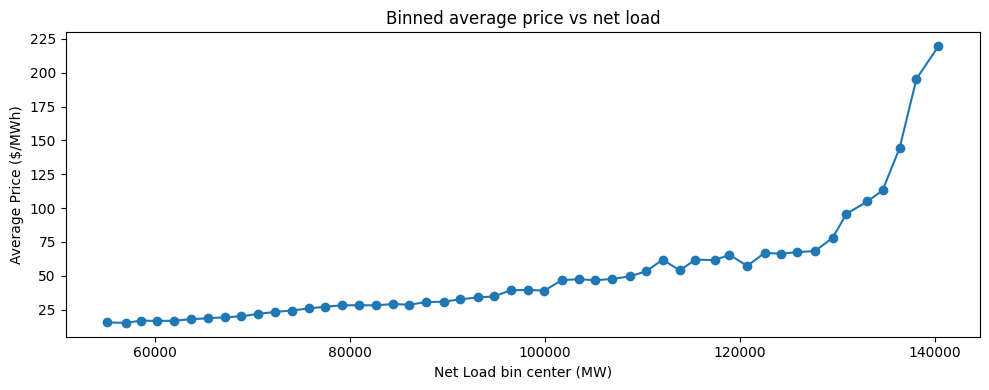

Saved plots/binned_price_vs_net_load.png
Saved csv_plots/binned_price_vs_net_load.csv


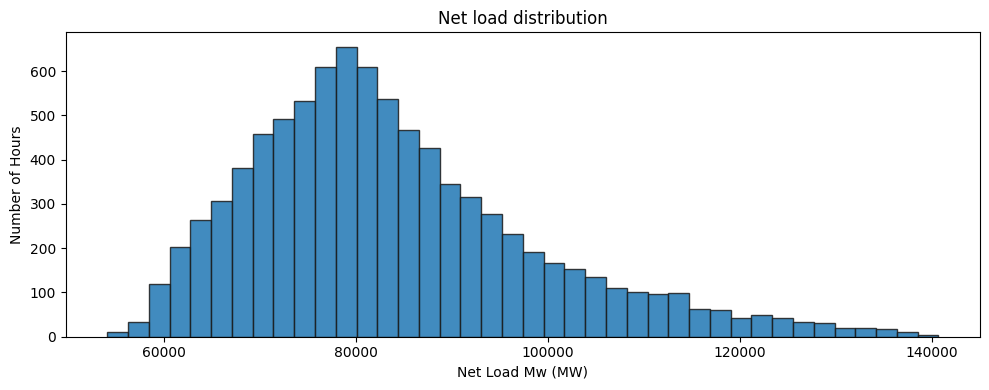

Saved plots/net_load_hist.png
Saved csv_plots/net_load_hist.csv


In [144]:
binned_price_plot(analysis_df, filename="binned_price_vs_net_load")
histogram_plot(analysis_df, column="net_load_mw", title="Net load distribution", filename="net_load_hist")

### Binned price & net-load distribution
- Marginal price impact is modest below ~110 GW but accelerates sharply beyond 125 GW, illustrating PJM’s scarcity impact on price.
- Net-load histogram is right-skewed: low-stress hours dominate counts, yet the thin tail of high-stress hours drives most price spikes.


## Polynomial regression of price vs net load

In [145]:
X = analysis_df[["net_load_mw"]].values
y = analysis_df["system_energy_price_da"].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
)

results = []
best_model = None
best_degree = None
best_test_r2 = -np.inf

for degree in range(1, 11):
    model = Pipeline([
        ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
        ("lin", LinearRegression())
    ])
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    r2_train = r2_score(y_train, train_pred)
    r2_test = r2_score(y_test, test_pred)
    rmse_train = root_mean_squared_error(y_train, train_pred)
    rmse_test = root_mean_squared_error(y_test, test_pred)
    results.append({
        "degree": degree,
        "train_r2": r2_train,
        "test_r2": r2_test,
        "train_rmse": rmse_train,
        "test_rmse": rmse_test
    })
    if r2_test > best_test_r2:
        best_degree = degree
        best_model = model
        best_test_r2 = r2_test

results_df = pd.DataFrame(results)
results_path = OUTPUT_DIR / "regression_results_corrected.csv"
results_df.to_csv(results_path, index=False)
print(f"Saved regression diagnostics to {results_path}")
results_df

Saved regression diagnostics to output_data/regression_results_corrected.csv


/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:288: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:288: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:288: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_
/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:288: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:288: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/alexj/code/CFT-E

,degree,train_r2,test_r2,train_rmse,test_rmse
0,1,0.437077,0.449878,14.409311,13.276540
1,2,0.486279,0.490517,13.765197,12.776753
2,3,0.501282,0.507433,13.562702,12.562849
3,4,0.503379,0.510299,13.534151,12.526249
4,5,0.505424,0.512940,13.506258,12.492427
5,6,0.507674,0.515525,13.475498,12.459230
6,7,0.510304,0.518059,13.439461,12.426611
7,8,0.513356,0.520370,13.397514,12.396779
8,9,0.516682,0.522140,13.351654,12.373879
9,10,0.519922,0.522971,13.306828,12.363122


### Polynomial regression notes
- Degree 10 captured the flat-to-steep curvature seen in the binned plot; lower degrees underfit the rapid price escalation at high net load.
- Train/test metrics stayed aligned, so the higher degree isn’t overfitting—there are enough observations to support the added flexibility.
- The fitted curve is economically intuitive: prices stay flat at low net load, then ramp as dispatch moves to peakers and scarcity pricing kicks in.


/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:288: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:288: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:288: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


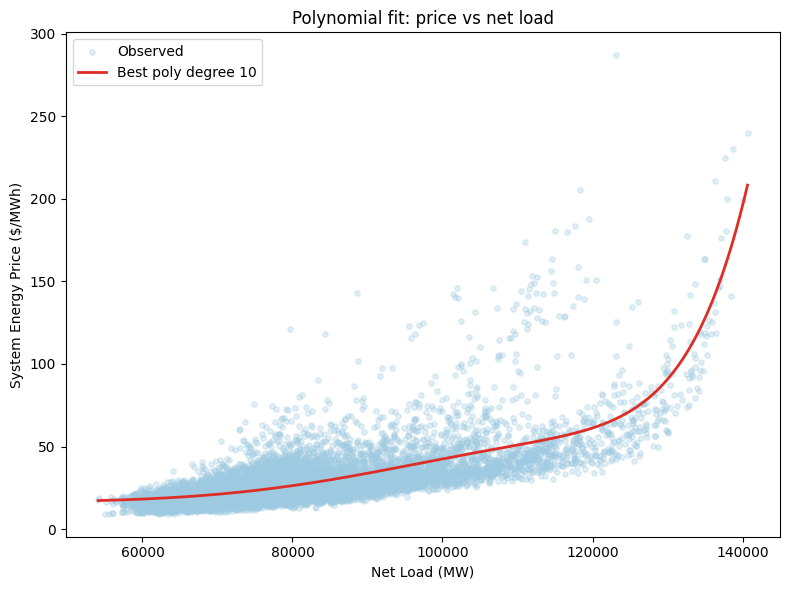

Saved plots/regression_best_fit.png


/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but PolynomialFeatures was fitted without feature names
  warnings.warn(
/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:288: RuntimeWarning: divide by zero encountered in matmul
  return X @ coef_ + self.intercept_
/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:288: RuntimeWarning: overflow encountered in matmul
  return X @ coef_ + self.intercept_
/Users/alexj/code/CFT-Energy-Analysis/.venv/lib/python3.12/site-packages/sklearn/linear_model/_base.py:288: RuntimeWarning: invalid value encountered in matmul
  return X @ coef_ + self.intercept_


,hour_beginning_ept,rto_load_mw,renewable_mw,system_energy_price_da,net_load_mw,month,month_name,day_name,hour,date,week,net_load_roll_24h,net_load_roll_168h,net_load_vol_24h,net_load_vol_168h,price_pred,price_residual
0,2023-10-06 00:00:00-04:00,74831,5138,20.98,69693,10,Oct,Friday,0,2023-10-06,40,69693.00,NaN,NaN,NaN,20.992994,-0.012994
1,2023-10-06 01:00:00-04:00,71800,4638,19.40,67162,10,Oct,Friday,1,2023-10-06,40,68427.50,NaN,NaN,NaN,20.077965,-0.677965
2,2023-10-06 02:00:00-04:00,69920,4674,17.80,65246,10,Oct,Friday,2,2023-10-06,40,67367.00,NaN,NaN,NaN,19.478655,-1.678655
3,2023-10-06 03:00:00-04:00,68972,4820,17.24,64152,10,Oct,Friday,3,2023-10-06,40,66563.25,NaN,NaN,NaN,19.170422,-1.930422
4,2023-10-06 04:00:00-04:00,70060,4651,18.04,65409,10,Oct,Friday,4,2023-10-06,40,66332.40,NaN,NaN,NaN,19.526649,-1.486649


In [146]:
net_grid = np.linspace(analysis_df["net_load_mw"].min(), analysis_df["net_load_mw"].max(), 500).reshape(-1, 1)
best_curve = best_model.predict(net_grid)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    analysis_df["net_load_mw"],
    analysis_df["system_energy_price_da"],
    alpha=0.3,
    s=15,
    color="#9ecae1",
    label="Observed"
)
ax.plot(net_grid, best_curve, color="#de2d26", linewidth=2, label=f"Best poly degree {best_degree}")
ax.set_xlabel("Net Load (MW)")
ax.set_ylabel("System Energy Price ($/MWh)")
ax.set_title("Polynomial fit: price vs net load")
ax.legend()
save_fig(fig, "regression_best_fit")

analysis_df["price_pred"] = best_model.predict(analysis_df[["net_load_mw"]])
analysis_df["price_residual"] = analysis_df["system_energy_price_da"] - analysis_df["price_pred"]
analysis_df.head()

## Price residuals vs net load

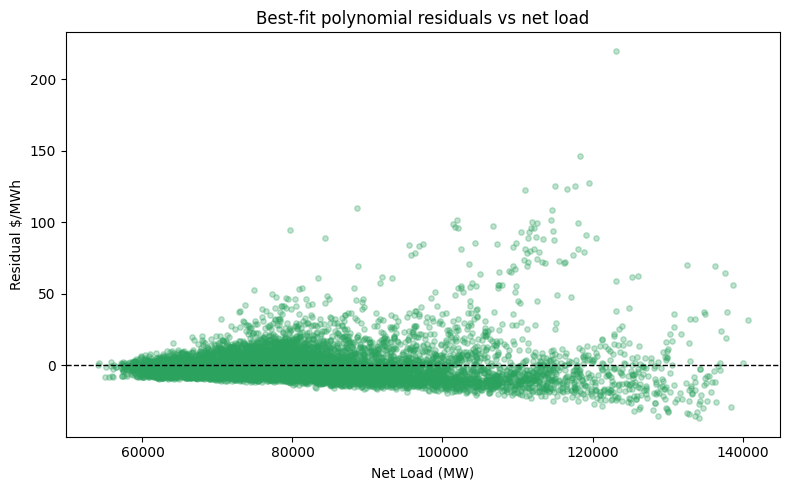

Saved plots/residuals_vs_net_load.png


In [147]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(
    analysis_df["net_load_mw"],
    analysis_df["price_residual"],
    alpha=0.3,
    s=15,
    color="#2ca25f"
)
ax.axhline(0, color="black", linewidth=1, linestyle="--")
ax.set_xlabel("Net Load (MW)")
ax.set_ylabel("Residual $/MWh")
ax.set_title("Best-fit polynomial residuals vs net load")
save_fig(fig, "residuals_vs_net_load")

### Price residuals vs net load
- Most points are close to zero, confirming net load explains most price variance.
- Positive residuals flag periods when price overshot fundamentals (fuel shortages, congestion, emergency actions).
- Negative residuals correspond to renewable surges or mild demand when prices cleared lower than the model expected.


## Residuals vs renewable output

Comparing price residuals to renewable output helps surface structural under/over-pricing tied to renewable availability.

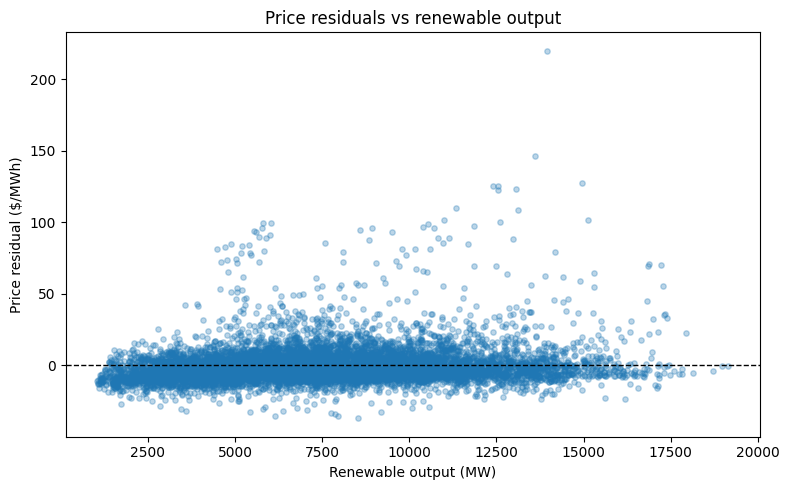

Saved plots/residuals_vs_renewable_output.png
Saved csv_plots/residuals_vs_renewable_output.csv


In [148]:

if "price_residual" not in analysis_df.columns:
    raise ValueError("price_residual not found. Run regression section first.")
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(
    analysis_df["renewable_mw"],
    analysis_df["price_residual"],
    alpha=0.3,
    s=15,
)
ax.axhline(0, color="black", linewidth=1, linestyle="--")
ax.set_xlabel("Renewable output (MW)")
ax.set_ylabel("Price residual ($/MWh)")
ax.set_title("Price residuals vs renewable output")
save_fig(fig, "residuals_vs_renewable_output")
save_plot_data(
    analysis_df[["renewable_mw", "price_residual"]],
    "residuals_vs_renewable_output",
)


### Residuals vs renewable MW
- Residuals tilt negative as renewable output increases, showing net-load-only models slightly understate the extra price suppression from high renewable share.
- Positive residual clusters coincide with low renewable MW, signalling attention points for fuel or outage constraints.


## Extreme net-load events

Highlighting the highest and lowest 1% of net-load hours contextualizes scarcity vs surplus conditions.

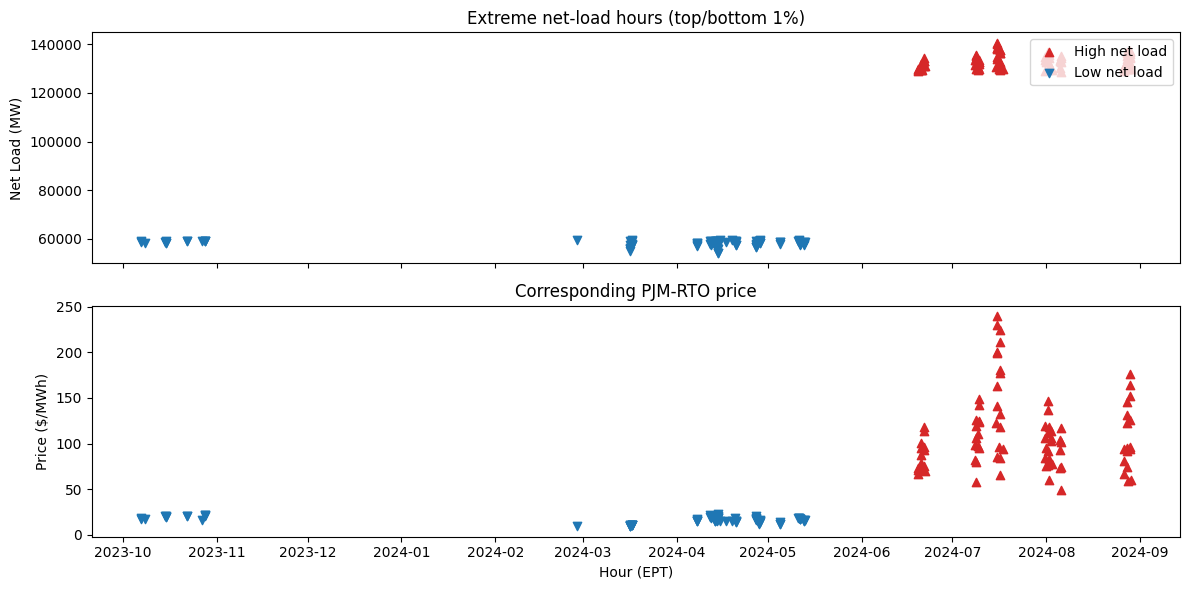

Saved plots/extreme_net_load_events.png
Saved csv_plots/extreme_net_load_events.csv


In [149]:

quantiles = analysis_df["net_load_mw"].quantile([0.01, 0.99])
low_thresh, high_thresh = quantiles.iloc[0], quantiles.iloc[1]
extremes = analysis_df[
    (analysis_df["net_load_mw"] <= low_thresh)
    | (analysis_df["net_load_mw"] >= high_thresh)
][
    [
        "hour_beginning_ept",
        "rto_load_mw",
        "renewable_mw",
        "net_load_mw",
        "system_energy_price_da",
        "month_name",
        "day_name",
    ]
].copy()
extremes["type"] = np.where(extremes["net_load_mw"] >= high_thresh, "High net load", "Low net load")

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
markers = {"High net load": "^", "Low net load": "v"}
colors = {"High net load": "tab:red", "Low net load": "tab:blue"}
for t in ["High net load", "Low net load"]:
    subset = extremes[extremes["type"] == t]
    axes[0].scatter(subset["hour_beginning_ept"], subset["net_load_mw"], marker=markers[t], color=colors[t], label=t)
    axes[1].scatter(subset["hour_beginning_ept"], subset["system_energy_price_da"], marker=markers[t], color=colors[t])
axes[0].set_ylabel("Net Load (MW)")
axes[0].set_title("Extreme net-load hours (top/bottom 1%)")
axes[0].legend(loc="upper right")
axes[1].set_ylabel("Price ($/MWh)")
axes[1].set_xlabel("Hour (EPT)")
axes[1].set_title("Corresponding PJM-RTO price")
plt.tight_layout()
save_fig(fig, "extreme_net_load_events")
save_plot_data(extremes, "extreme_net_load_events")


### Extreme net-load events
- High net-load markers concentrate during winter cold snaps and late-summer heat waves, each paired with elevated prices in the lower subplot.
- Low net-load events appear on mild spring weekends, where abundant renewables and weak demand collapse prices.
- The exported CSV provides timestamps plus load/renewable/price context for deeper case studies.


## Findings summary

- Net load is consistently lower than gross RTO load by the renewable fleet contribution, confirming the corrected definition.
- Energy prices show pronounced hour-of-day and month seasonality; weekends trend lower.
- Renewable output peaks overnight for wind and during daytime for solar, compressing net load and moderating prices.
- Polynomial regression indicates diminishing returns after the degree that maximizes R². Residual analysis highlights volatility not captured by net load alone, suggesting future additions such as fuel prices or outages.

## Autocorrelation diagnostics

Autocorrelation highlights how quickly system net load and prices lose memory of prior hours, informing how far ahead simple time-series models may stay informative.

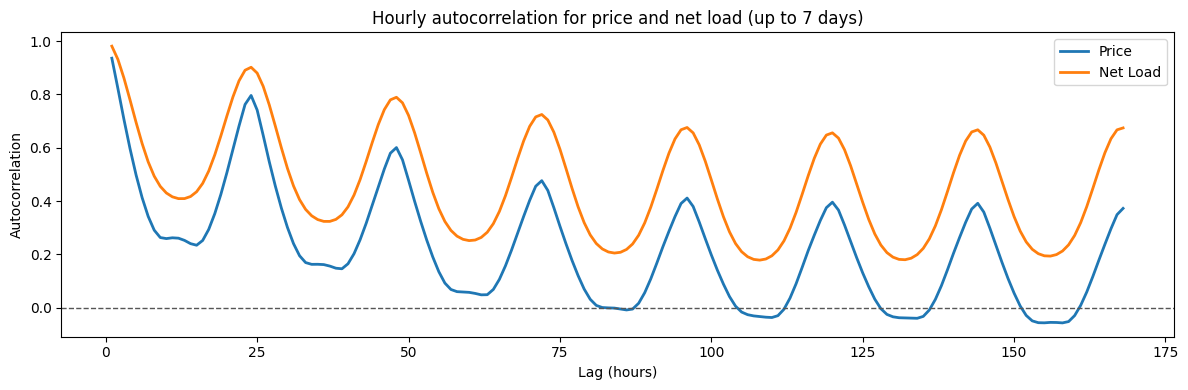

Saved plots/autocorr_price_net_load.png


In [150]:
lags = range(1, 169)  # one week of hourly lags
acf_price = [analysis_df['system_energy_price_da'].autocorr(lag=l) for l in lags]
acf_net = [analysis_df['net_load_mw'].autocorr(lag=l) for l in lags]

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(lags, acf_price, label='Price', linewidth=2)
ax.plot(lags, acf_net, label='Net Load', linewidth=2)
ax.axhline(0, color='#555', linewidth=1, linestyle='--')
ax.set_xlabel('Lag (hours)')
ax.set_ylabel('Autocorrelation')
ax.set_title('Hourly autocorrelation for price and net load (up to 7 days)')
ax.legend()
save_fig(fig, 'autocorr_price_net_load')


### Autocorrelation interpretation
- Net load retains daily (~24h) and weekly (~168h) memory, guiding short-term forecast horizons.
- Price autocorrelation decays faster, highlighting the added noise from fuel prices, outages, and market interventions beyond the load signal.


## Combined view of trend and density

Binning net load and pairing it with stacked histograms highlights where observations cluster, complementing the hue-based scatterplots.